# 미니프로젝트1: 비정상 데이터를 정상 데이터로 만들기
1949년부터 1960년까지 매월 US 항공사 승객들의 수를 집계한 데이터셋(AirPassengers)을 사용한다.

- 진행순서
  1. AirPassengers데이터 불러오기
  2. **분산을 일정**하게 만들기 - log transformation
  3. 차분을 통해 **추세 제거**하기
  4. 계절 차분을 통해 **계절성 제거**하기
  5. 검정을 통해 **정상성 확인**하기


## 1. AirPassengers데이터 불러오기
---
- 데이터가 있는 폴더 연결하기
- 필요한 라이브러리 불러오기
- 데이터 불러오기





In [1]:
# 구글 드라이브와 연동
from google.colab import drive
drive.mount('/content/drive')

# 파일 경로 수정
import os
print('os.getcwd():',os.getcwd())
os.chdir('/content/drive/MyDrive/Colab Notebooks/07_Time_Series/data')
print('os.getcwd():',os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
os.getcwd(): /content
os.getcwd(): /content/drive/MyDrive/Colab Notebooks/07_Time_Series/data


In [2]:
# 필요한 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller

In [3]:
# AirPassengers 데이터 불러오기
ap = pd.read_csv('AirPassengers.csv')

In [4]:
# 데이터 정보 확인
ap.info()
display(ap.head(3))
display(ap.tail(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


,Month,#Passengers
141,1960-10,461
142,1960-11,390
143,1960-12,432


승객수를 그래프로 시각화 해본다.

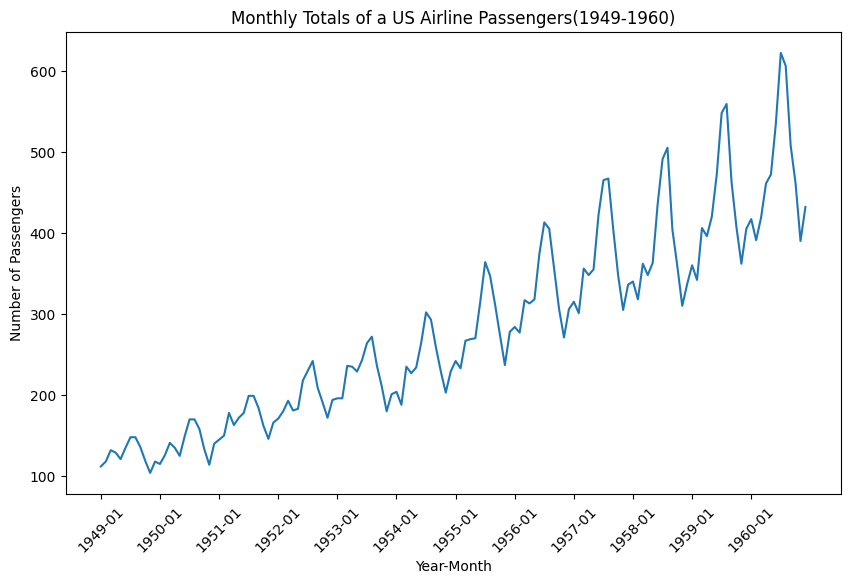

In [5]:
# Passengers를 그래프로 시각화
plt.figure(figsize=(10,6))
plt.plot(ap['Month'], ap['#Passengers'])
plt.title('Monthly Totals of a US Airline Passengers(1949-1960)')
plt.xlabel('Year-Month')
plt.xticks(np.arange(0, len(ap.index), 12), rotation = 45)
plt.ylabel('Number of Passengers')
plt.show()

- 시간이 지나갈수록 승객 수가 점점 증가하는 추세를 보인다.
- 1월부터 12월까지에서 상승과 하강을 보이는 패턴이 매년 반복적으로 보이는 계절성이 나타난다.
- 시간이 갈수록 1월부터 12월까지 상승과 하락의 폭이 증가하면서 분산이 일정하지 않고 계속 증가하는 패턴을 보인다.

따라서, 해당 시계열데이터를 사용하기 위해 추세, 계절성을 제거하고 분산을 일정하게 해줄 필요가 있다.

## 2. 분산을 일정하게 만들기 - log transformation
- 승객수를 로그변환해준 뒤 시각화하여 분산이 일정해졌는지 확인

In [6]:
# log transformation
ap['log_passengers'] = np.log(ap['#Passengers'])
ap

,Month,#Passengers,log_passengers
0,1949-01,112,4.718499
1,1949-02,118,4.770685
2,1949-03,132,4.882802
3,1949-04,129,4.859812
4,1949-05,121,4.795791
...,...,...,...
139,1960-08,606,6.406880
140,1960-09,508,6.230481
141,1960-10,461,6.133398
142,1960-11,390,5.966147


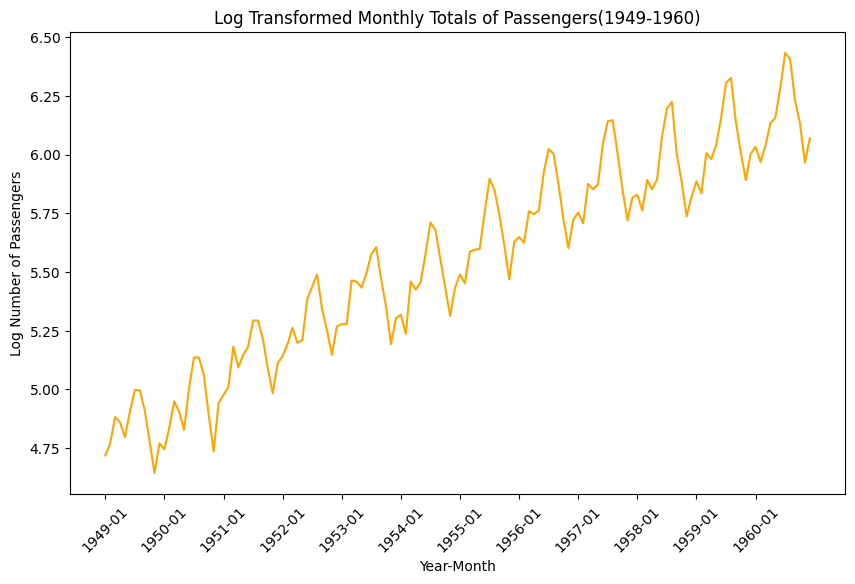

In [7]:
# log_passengers 시각화
plt.figure(figsize=(10,6))
plt.plot(ap['Month'], ap['log_passengers'], color = 'orange')
plt.title('Log Transformed Monthly Totals of Passengers(1949-1960)')
plt.xlabel('Year-Month')
plt.xticks(np.arange(0, len(ap.index), 12), rotation = 45)
plt.ylabel('Log Number of Passengers')
plt.show()

- 로그변환으로 인해 승객수가 scale이 줄어들었고 매년 늘어나던 분산이 거의 일정해졌음을 알수 있다.
- 하지만 여전히 계절성과 추세가 존재함을 알 수 있다.

## 3. 차분을 통해 추세 제거하기
- 로그변환된 승객수에 1차 차분을 한 뒤 추세가 제거되었는지 시각화를 통해 확인



In [8]:
# diff()를 통해 로그변환한 승객수에 차분을 수행
ap['diffed_log_passengers'] = ap['log_passengers'].diff()
ap.dropna(inplace=True)  # 차분으로 발생하는 결측치 제거
ap

,Month,#Passengers,log_passengers,diffed_log_passengers
1,1949-02,118,4.770685,0.052186
2,1949-03,132,4.882802,0.112117
3,1949-04,129,4.859812,-0.022990
4,1949-05,121,4.795791,-0.064022
5,1949-06,135,4.905275,0.109484
...,...,...,...,...
139,1960-08,606,6.406880,-0.026060
140,1960-09,508,6.230481,-0.176399
141,1960-10,461,6.133398,-0.097083
142,1960-11,390,5.966147,-0.167251


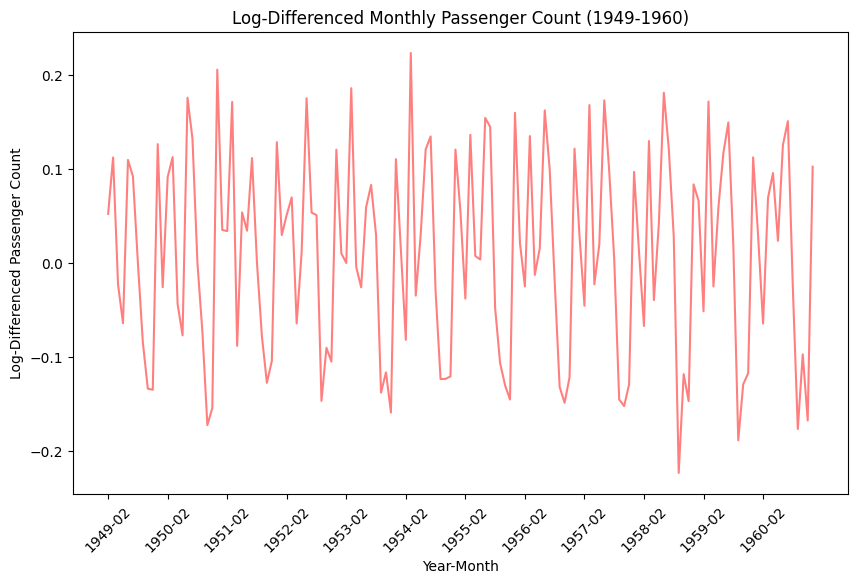

In [9]:
# diffed_log_passengers을 시각화
plt.figure(figsize=(10,6))
plt.plot(ap['Month'], ap['diffed_log_passengers'], color = 'red', alpha = 0.5)
plt.title('Log-Differenced Monthly Passenger Count (1949-1960)')
plt.xlabel('Year-Month')
plt.xticks(np.arange(0, len(ap.index), 12), rotation = 45)
plt.ylabel('Log-Differenced Passenger Count')
plt.show()

- 시간의 추세에 따라 증가하는 경향이 사라졌다.
- 또한 차분이 되어 y축의 범위가 줄어들었음을 확인할 수 있다.

하지만, 12개월을 주기로 계절성이 여전히 보인다.

## 4. 계절 차분을 통해 계절성 제거하기
- 주기를 12로 하는 계절 차분을 수행한 뒤 시각화여 계절성이 제거되었는지 확인

<br><br>

**<참고>**
- 1차 차분 + 계절성 차분: 주기가 다른 두 차분을 독립적으로 수행(2차차분과는 다름)
  - 1차 차분 → 추세 제거
  - 계절성 차분 → 계절 패턴 제거


In [10]:
# 주기를 12로하는 계절 차분 수행
ap['seasonally_diff'] = ap['diffed_log_passengers'].diff(12)
ap.dropna(inplace = True)  # 차분으로 생기는 결측치 제거
ap

,Month,#Passengers,log_passengers,diffed_log_passengers,seasonally_diff
13,1950-02,126,4.836282,0.091350,0.039164
14,1950-03,141,4.948760,0.112478,0.000361
15,1950-04,135,4.905275,-0.043485,-0.020496
16,1950-05,125,4.828314,-0.076961,-0.012939
17,1950-06,149,5.003946,0.175633,0.066148
...,...,...,...,...,...
139,1960-08,606,6.406880,-0.026060,-0.045934
140,1960-09,508,6.230481,-0.176399,0.012024
141,1960-10,461,6.133398,-0.097083,0.031830
142,1960-11,390,5.966147,-0.167251,-0.050082


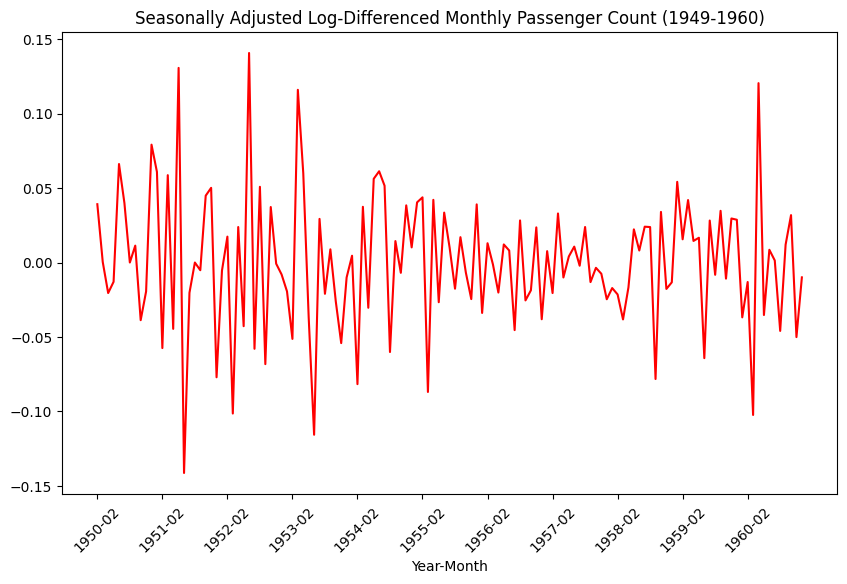

In [11]:
# 계절성 차분을 적용한 데이터 시각화
plt.figure(figsize=(10,6))
plt.plot(ap['Month'], ap['seasonally_diff'], color = 'red')
plt.title('Seasonally Adjusted Log-Differenced Monthly Passenger Count (1949-1960)')
plt.xlabel('Year-Month')
plt.xticks(np.arange(0, len(ap.index), 12), rotation = 45)
plt.show()

- 계절성이 제거되었음을 확인할 수 있다.

## 5. 검정을 통해 정상성 확인하기
$$
H_0: \text{계절차분된 Passengers 시계열 데이터에 단위근이 존재한다.}  \\
H_1: \text{계절차분된 Passengers 시계열 데이터는 정상성을 만족한다.}
$$


In [12]:
# adf검정을 위한 함수 정의
def adf_test(x):
  stat, p_value, lags, nobs, crit, icb = adfuller(x)
  print('ADF statistics')
  print(stat)  # 검정통계량
  print('P-value')
  print(p_value)

In [13]:
# 계절차분으로 수행한 데이터를 이용해 adf test진행
adf_test(ap['seasonally_diff'])

ADF statistics
-4.4433249418311425
P-value
0.00024859123113838495


- 유의수준 0.01에서 단위근이 존재한다는 귀무가설을 기각하고 해당 시계열 데이터가 정상적이다라고 할 수 있다.

# 미니프로젝트2: 3가지 분류 모델을 이용하여 시계열 분류 모델의 성능 올리기
- 진행순서
  1. 데이터 설명 및 불러오기
    - 사용할 데이터셋 설명
    - 시계열 데이터를 다루기 위한 라이브러리 설치
    - 필요한 라이브러리 불러오기
    - 데이터 불러오기
  2. 데이터 탐색 및 데이터셋 나누기
    - 불러온 데이터 확인
    - 훈련데이터와 검증데이터로 나누기
  3. 특징 추출 및 결측치 데이터 처리
    - 특징 추출하기
    - 결측치 데이터 전처리 하기
  4. 분류 모델 성능 비교 - 정확도
    - Logistic Regression
    - RandomForest
    - XGBoost
  5. Classification report를 통한 검증 및 분석
    - XGBoost모델
  


## 1. 데이터 설명 및 불러오기

### 사용할 데이터셋 설명
- 출처: https://archive.ics.uci.edu/dataset/138/robot+execution+failures
- 위의 사이트에서 데이터파일을 다운로드 받아 데이터에 관한 설명문서 참고하였다.
- 해당 데이터셋은 로봇의 힘과 토크(torque, 돌림힘) 데이터를 포함한다.
- 각각의 고장데이터는 일정 시간 간격에서 15개의 힘/토크 표본들로 구성되어 있다.
- 우리가 사용하는 데이터는 LP1 데이터셋으로, 해당 데이터는 구체적으로 로봇이 물체를 잡기 위해 정확한 위치로 이동하는 동안 예상치 못한 문제가 발생하여 잡기에 실패하는 경우에 발생한 데이터로 추정된다.
- 실제 데이터에서는 target 데이터가 이진분류가 아닌, 다중분류로 되어 있다.
```
  - 24%: normal
  - 19%: collision
  - 18%: front collision
  - 39%: obstruction
```
  으로 이루어져 있으며, 우리가 다룰 데이터에서는 정상인 여부만 따져 24%에 해당하는 21개의 id에 대해서는 True, 고장인 나머지 id에 대해서는 False로 라벨링한 것으로 추정된다.




### 시계열 데이터를 다루기 위한 라이브러리 설치

In [14]:
# tsfresh 설치
!pip install tsfresh

  Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.2 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


- tsfresh를 설치하다가 에러가 발생함.
```
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
```

따라서 scipy의 성능을 낮춰 다시 설치해준다.

In [15]:
# scipy버전 낮추기
!pip install scipy==1.13.1

  Using cached scipy-1.13.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.13.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


### 필요한 라이브러리 불러오기

In [16]:
# 필요한 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# 데이터셋 가공
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters, ComprehensiveFCParameters, MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute

# 데이터 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 분류모델 평가
from sklearn.metrics import classification_report

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### 데이터 불러오기

In [17]:
# robot execution failures 데이터 불러오기
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

## 2. 데이터 탐색 및 데이터셋 나누기
- 불러온 데이터 확인
- 훈련데이터와 검증데이터로 나누기

### 불러온 데이터 확인

#### timeseries 데이터셋

In [18]:
# 데이터셋 확인 - feature
timeseries

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


time의 고유값 개수:  15
time의 고유값:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


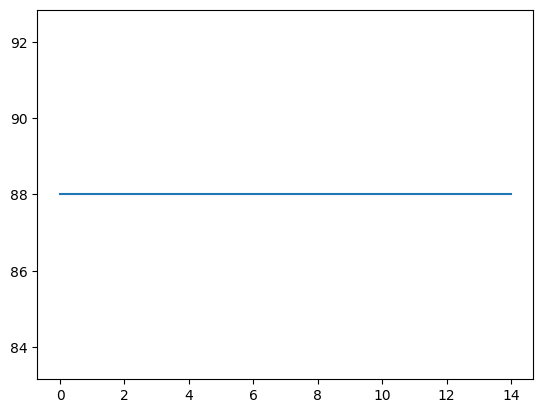

In [19]:
# time에 관한 정보 확인
print('time의 고유값 개수: ', timeseries['time'].nunique())
print('time의 고유값: ', timeseries['time'].unique())

# time의 개수 분포 확인
time_data = timeseries['time'].value_counts().sort_index()
plt.plot(time_data.index, time_data.values)
plt.show()

id의 고유값 개수:  88
id의 고유값:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]


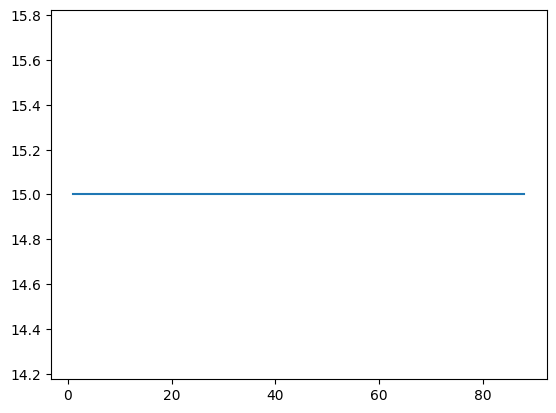

In [20]:
# id에 관한 정보 확인
print('id의 고유값 개수: ', timeseries['id'].nunique())
print('id의 고유값: ', timeseries['id'].unique())

# id의 개수 분포 확인 - 모두 15개로 되어 있는지
id_data = timeseries['id'].value_counts().sort_index()
plt.plot(id_data.index, id_data.values)
plt.show()

- id가 1부터 88까지 88개의 로봇에 대해 각각 15번씩 x,y,z축에 대한 힘과 토크 데이터를 수집했음을 알수 있다.

#### y 데이터셋

In [21]:
y

,0
1,True
2,True
3,True
4,True
5,True
...,...
84,False
85,False
86,False
87,False


In [22]:
# y의 구성
print('y == True인 데이터: ', len(y[y==True]), round(y.mean(), 2))
print('y == False인 데이터: ', len(y[y==False]), round(len(y[y==False])/len(y),2))

y == True인 데이터:  21 0.24
y == False인 데이터:  67 0.76


- 88개의 로봇에 대해서 고장여부를 labeling한 것으로 보여진다.
- 고장나지 않은 로봇이 21개로 약 24%정도를 차지하고, 고장난 로봇이 67%로 약 76%를 차지함을 확인할 수 있다.

### 훈련데이터와 검증데이터로 나누기


In [23]:
# 데이터셋을 나누는 함수를 생성
def custom_classification_split(x, y, test_size=0.3):

  num_true = int(y.sum()*test_size)
  num_false = int((len(y) - y.sum())*test_size)

  id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()

  y_train = y.drop(id_list)
  y_test = y.iloc[id_list].sort_index()
  X_train = x[~x['id'].isin(id_list)]
  X_test = x[x['id'].isin(id_list)]

  print(f'훈련데이터 X,y shape: {X_train.shape}, {y_train.shape}')
  print(f'검증데이터 X,y shape: {X_test.shape}, {y_test.shape}')

  return X_train, y_train, X_test, y_test

In [24]:
# 데이터셋 나누기
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size = 0.25)

훈련데이터 X,y shape: (1005, 8), (67,)
검증데이터 X,y shape: (315, 8), (21,)


## 3. 특징 추출 및 결측치 데이터 처리
- 특징 추출하기
- 결측치 데이터 전처리 하기

### 특징 추출하기
- **ComprehensiveFCParameters**: 모든 특징을 추출

- **EfficientFCParameters**: 큰 계산비용이 필요한 calculator를 제외하고 가능한 모든 특징을 생성

- **MinimalFCParameters**: 최소한의 유용한 특징만을 추출



#### ComprehensiveFCParameters

In [25]:
settings = ComprehensiveFCParameters()

# train데이터의 특징 추출
comprehensive_feature_train = extract_features(X_train,
                                               column_id = 'id',
                                               column_sort = 'time',
                                               default_fc_parameters= settings)
print(comprehensive_feature_train.shape)
display(comprehensive_feature_train.head(2))

# test데이터의 특징 추출
comprehensive_feature_test = extract_features(X_test,
                                               column_id = 'id',
                                               column_sort = 'time',
                                               default_fc_parameters= settings)
print(comprehensive_feature_test.shape)
display(comprehensive_feature_test.head(2))

Feature Extraction: 100%|██████████| 402/402 [01:12<00:00,  5.56it/s]


(67, 4698)


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,NaN,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,NaN,0.428571


Feature Extraction: 100%|██████████| 126/126 [00:14<00:00,  8.47it/s]


(21, 4698)


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.0,-0.038462,-1.0,...,NaN,NaN,NaN,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,NaN,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.0,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.83102,NaN,0.571429


- 특징을 추출하면서 데이터개수가 target데이터와 같아졌다. 다른 방법으로도 특징을 생성해본다.

#### EfficientFCParameters

In [26]:
# EfficientFCParameters을 이용해 특징 추출
settings = EfficientFCParameters()

# train데이터의 특징 추출
efficient_feature_train = extract_features(X_train,
                                               column_id = 'id',
                                               column_sort = 'time',
                                               default_fc_parameters= settings)
print(efficient_feature_train.shape)
display(efficient_feature_train.head(2))

# test데이터의 특징 추출
efficient_feature_test = extract_features(X_test,
                                               column_id = 'id',
                                               column_sort = 'time',
                                               default_fc_parameters= settings)
print(efficient_feature_test.shape)
display(efficient_feature_test.head(2))

Feature Extraction: 100%|██████████| 402/402 [00:46<00:00,  8.56it/s]


(67, 4662)


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,NaN,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,NaN,0.428571


Feature Extraction: 100%|██████████| 126/126 [00:15<00:00,  8.05it/s]


(21, 4662)


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.0,-0.038462,-1.0,...,NaN,NaN,NaN,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,NaN,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.0,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.83102,NaN,0.571429


#### MinimalFCParameters

In [27]:
# MinimalFCParameters을 이용해 특징 추출
settings = MinimalFCParameters()

# train데이터의 특징 추출
minimal_feature_train = extract_features(X_train,
                                               column_id = 'id',
                                               column_sort = 'time',
                                               default_fc_parameters= settings)
print(minimal_feature_train.shape)
display(minimal_feature_train.head(2))

# test데이터의 특징 추출
minimal_feature_test = extract_features(X_test,
                                               column_id = 'id',
                                               column_sort = 'time',
                                               default_fc_parameters= settings)
print(minimal_feature_test.shape)
display(minimal_feature_test.head(2))

Feature Extraction: 100%|██████████| 402/402 [00:00<00:00, 2127.23it/s]


(67, 60)


,F_x__sum_values,F_x__median,F_x__mean,F_x__length,F_x__standard_deviation,F_x__variance,F_x__root_mean_square,F_x__maximum,F_x__absolute_maximum,F_x__minimum,...,T_z__sum_values,T_z__median,T_z__mean,T_z__length,T_z__standard_deviation,T_z__variance,T_z__root_mean_square,T_z__maximum,T_z__absolute_maximum,T_z__minimum
6,-15.0,-1.0,-1.000000,15.0,1.264911,1.600000,1.612452,1.0,3.0,-3.0,...,-3.0,0.0,-0.200000,15.0,0.541603,0.293333,0.577350,1.0,1.0,-1.0
7,-13.0,-1.0,-0.866667,15.0,0.805536,0.648889,1.183216,0.0,3.0,-3.0,...,-1.0,0.0,-0.066667,15.0,0.442217,0.195556,0.447214,1.0,1.0,-1.0


Feature Extraction: 100%|██████████| 126/126 [00:00<00:00, 1279.89it/s]


(21, 60)


,F_x__sum_values,F_x__median,F_x__mean,F_x__length,F_x__standard_deviation,F_x__variance,F_x__root_mean_square,F_x__maximum,F_x__absolute_maximum,F_x__minimum,...,T_z__sum_values,T_z__median,T_z__mean,T_z__length,T_z__standard_deviation,T_z__variance,T_z__root_mean_square,T_z__maximum,T_z__absolute_maximum,T_z__minimum
1,-14.0,-1.0,-0.933333,15.0,0.249444,0.062222,0.966092,0.0,1.0,-1.0,...,0.0,0.0,0.000000,15.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,-13.0,-1.0,-0.866667,15.0,0.956847,0.915556,1.290994,0.0,3.0,-3.0,...,-4.0,0.0,-0.266667,15.0,0.442217,0.195556,0.516398,0.0,1.0,-1.0


### 결측치 데이터 처리
- `tsfresh.utilities.dataframe_functions.impute(df_impute)`: 결측치 데이터를 같은 컬럼에 있는 평균이나 극단으로 대체해준다.
  - `-inf`-> `min`
  - `+inf`-> `max`
  - `NaN`-> `median`

In [28]:
# Impute: ComprehensiveFCParameters
impute(comprehensive_feature_train)
impute(comprehensive_feature_test)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


- **ComprehensiveFCParameters**으로 4698개의 특징이 추출되었다.

In [29]:
# Impute: EfficientFCParameters
impute(efficient_feature_train)
impute(efficient_feature_test)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


- **EfficientFCParameters**으로 4662개의 특징이 추출되었다.

In [30]:
# Impute: MinimalFCParameters
impute(minimal_feature_train)
impute(minimal_feature_test)

,F_x__sum_values,F_x__median,F_x__mean,F_x__length,F_x__standard_deviation,F_x__variance,F_x__root_mean_square,F_x__maximum,F_x__absolute_maximum,F_x__minimum,...,T_z__sum_values,T_z__median,T_z__mean,T_z__length,T_z__standard_deviation,T_z__variance,T_z__root_mean_square,T_z__maximum,T_z__absolute_maximum,T_z__minimum
1,-14.0,-1.0,-0.933333,15.0,0.249444,0.062222,0.966092,0.0,1.0,-1.0,...,0.0,0.0,0.000000,15.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,-13.0,-1.0,-0.866667,15.0,0.956847,0.915556,1.290994,0.0,3.0,-3.0,...,-4.0,0.0,-0.266667,15.0,0.442217,0.195556,0.516398,0.0,1.0,-1.0
3,-10.0,-1.0,-0.666667,15.0,0.596285,0.355556,0.894427,1.0,1.0,-1.0,...,-4.0,0.0,-0.266667,15.0,0.442217,0.195556,0.516398,0.0,1.0,-1.0
4,-6.0,0.0,-0.400000,15.0,0.952190,0.906667,1.032796,1.0,2.0,-2.0,...,-5.0,0.0,-0.333333,15.0,0.596285,0.355556,0.683130,1.0,1.0,-1.0
5,-9.0,-1.0,-0.600000,15.0,0.879394,0.773333,1.064581,2.0,2.0,-2.0,...,-2.0,0.0,-0.133333,15.0,0.618241,0.382222,0.632456,1.0,1.0,-1.0
19,99.0,1.0,6.600000,15.0,19.071095,363.706667,20.180849,69.0,69.0,-12.0,...,6.0,0.0,0.400000,15.0,0.952190,0.906667,1.032796,2.0,2.0,-1.0
20,155.0,-1.0,10.333333,15.0,46.799810,2190.222222,47.927028,185.0,185.0,-10.0,...,10.0,0.0,0.666667,15.0,3.112698,9.688889,3.183290,12.0,12.0,-2.0
21,-171.0,-1.0,-11.400000,15.0,31.140113,969.706667,33.161222,13.0,119.0,-119.0,...,80.0,0.0,5.333333,15.0,25.029760,626.488889,25.591665,98.0,98.0,-14.0
22,102.0,-1.0,6.800000,15.0,28.291813,800.426667,29.097537,112.0,112.0,-5.0,...,-31.0,0.0,-2.066667,15.0,7.279805,52.995556,7.567474,1.0,29.0,-29.0
23,67.0,-3.0,4.466667,15.0,26.196353,686.248889,26.574424,95.0,95.0,-29.0,...,11.0,0.0,0.733333,15.0,2.792052,7.795556,2.886751,6.0,6.0,-4.0


In [31]:
minimal_feature_test.shape

(21, 60)

- **MinimalFCParameters**으로 60개의 특징이 추출되었다.

## 4. 분류 모델 성능 비교 - 정확도
- 위에서 사용한 3가지 특징추출 방법을 따라 모델의 정확도를 비교한다.
- 사용할 모델
  - Logistic Regression
  - RandomForest
  - XGBoost

In [32]:
# 다양한 분류모형 생성
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier(n_estimators=10, random_state=42)
xgb_clf = XGBClassifier(n_estimators=10, max_depth=3, random_state=42)

models = [lr_clf, rf_clf, xgb_clf]

def fit_clf_models(models, X, y):
  for model in models:
    print('\n##### fit', model.__class__.__name__, '#####')
    model.fit(X,y)

def score_clf_models(models, X, y):
  for model in models:
    print('\n#####', model.__class__.__name__, '#####')
    print(f'Accuracy score: {model.score(X,y)}')


### ComprehensiveFCParameters

In [33]:
fit_clf_models(models, comprehensive_feature_train, y_train)
score_clf_models(models, comprehensive_feature_test, y_test)


##### fit LogisticRegression #####

##### fit RandomForestClassifier #####

##### fit XGBClassifier #####

##### LogisticRegression #####
Accuracy score: 0.5714285714285714

##### RandomForestClassifier #####
Accuracy score: 0.9523809523809523

##### XGBClassifier #####
Accuracy score: 1.0


- 모든 특징을 추출했을 경우, XGB > RandomForest >> LogisticRegression 순으로 성능이 좋게 나왔다.
- LogisticRegression이 약 0.57로 다른 두 모델에 비해 성능이 차이가 존재한다.

### EfficientFCParameters

In [34]:
fit_clf_models(models, efficient_feature_train, y_train)
score_clf_models(models, efficient_feature_test, y_test)


##### fit LogisticRegression #####

##### fit RandomForestClassifier #####

##### fit XGBClassifier #####

##### LogisticRegression #####
Accuracy score: 0.5714285714285714

##### RandomForestClassifier #####
Accuracy score: 0.8095238095238095

##### XGBClassifier #####
Accuracy score: 1.0


- 큰 계산비용이 드는 특징을 제외한 경우에도,  XGB > RandomForest >> LogisticRegression 순으로 성능이 좋게 나왔다.
- LogisticRegression이 약 0.57로 다른 두 모델에 비해 성능이 차이가 존재한다.

### MinimalFCParameters

In [35]:
fit_clf_models(models, minimal_feature_train, y_train)
score_clf_models(models, minimal_feature_test, y_test)


##### fit LogisticRegression #####

##### fit RandomForestClassifier #####

##### fit XGBClassifier #####

##### LogisticRegression #####
Accuracy score: 0.8095238095238095

##### RandomForestClassifier #####
Accuracy score: 0.9523809523809523

##### XGBClassifier #####
Accuracy score: 1.0


- **LogisticRegression**에서는 최소의 특징을 추출해서 모델을 적합했을 때 정확도가 약 0.81로 가장 높게 나왔다. 다른 방법으로 추출했을 경우가 과적합되어 정확도가 낮게 나온 것으로 추측된다.
- **XGBClassifier**의 경우 특징 추출 방법에 관계없이 모두 정확도가 1로 가장 높게 나왔다. 또한 random_state의 값에 영향을 받지 않았다.
- **RandomForestClassifier**의 경우 **특징 추출방법**에 따라 성능의 차이를 보였을뿐만 아니라 **random_state**에 어떤 숫자를 넣느냐에 따라 성능 차이를 보였다. EfficientFCParameters으로 random_state=1111로 모델적합을 한 경우 정확도는 0.33으로 매우 낮게 나왔고, random_state=2024로 했을 경우 정확도가 1이 나오는 등 성능차이를 크게 보였다. 이외에 random_state, n_estimators, max_depth 등의 하이퍼파라미터를 튜닝했을 때 보통 성능은   
  Comprehensive = Minimal > Efficient  
  혹은   
  Minimal > Efficient > Comprehensive  
순으로, MinimalFCParameters에서 대체로 높은 성능을 보였다.

따라서, 특징추출방법에 관계없이 정확도가 1이 나온 xgboost모델의 성능을 교차표를 그려 확인해보려고 한다.



## 5. Classification report를 통한 검증 및 분석
- MinimalFCParameters방법으로 추출한 특징에 대해 적합한 XGBoost모델에 대해 교차표를 나타내면 아래와 같다.

In [36]:
# xgboost - MinimalFCParameters
xgb_clf = XGBClassifier(n_estimators=10, max_depth=3, random_state=42)
xgb_clf.fit(comprehensive_feature_train, y_train)

print(classification_report(y_test, xgb_clf.predict(comprehensive_feature_test),
                      target_names=['True', 'False']))

              precision    recall  f1-score   support

        True       1.00      1.00      1.00        16
       False       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



- True, False 비중이 16:5로 불균형 데이터였음에도 정확도가 1로, 모델이 로봇의 고장여부를 잘 예측했다고 할 수 있다. 정확도가 1이므로 recall,  precision, f1-score 역시 1이됨을 알 수 있다.

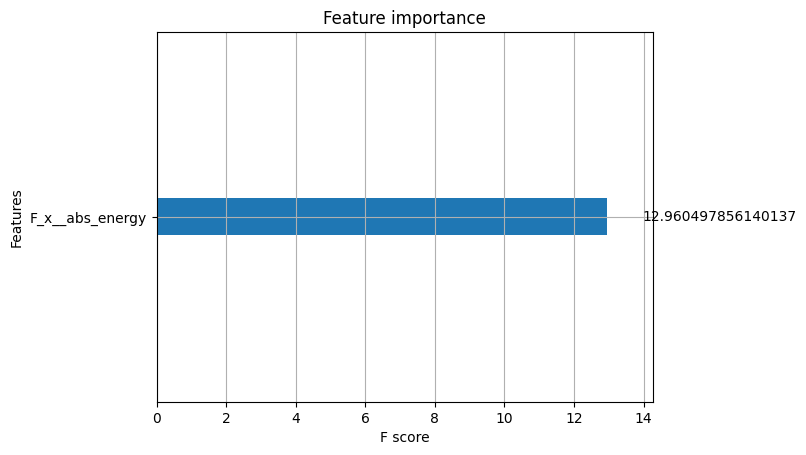

In [37]:
# 참고: plot_importance로 유의미한 변수 확인
import xgboost
xgboost.plot_importance(xgb_clf, importance_type = 'gain')
# importance_type = 'weight', 'cover'의 경우도 모두 F_x_abs_energy만 나옴
plt.show()